## Notebook libraries/Functions

In [3]:
import os
import glob
from datetime import datetime, timezone

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

import xarray as xr

from PIL import Image

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

### Define path

In [4]:
def get_path(parts):
    out_path = ""
    for part in parts:
        out_path = out_path + f"{part}{os.path.sep}"

    out_path = out_path.rstrip(os.path.sep)
    return out_path

### Get x, y from longitude, latitude

In [5]:
def _hemi_direction(hemisphere):
    """Return `1` for 'north' and `-1` for 'south'"""
    return {"north": 1, "south": -1}[hemisphere]


def polar_lonlat_to_xy(longitude, latitude, true_scale_lat, re, e, hemisphere):
    """Convert from geodetic longitude and latitude to Polar Stereographic
    (X, Y) coordinates in km.

    Args:
        longitude (float): longitude or longitude array in degrees
        latitude (float): latitude or latitude array in degrees (positive)
        true_scale_lat (float): true-scale latitude in degrees
        re (float): Earth radius in km
        e (float): Earth eccentricity
        hemisphere ('north' or 'south'): Northern or Southern hemisphere

    Returns:
        If longitude and latitude are scalars then the result is a
        two-element list containing [X, Y] in km.
        If longitude and latitude are numpy arrays then the result will be a
        two-element list where the first element is a numpy array containing
        the X coordinates and the second element is a numpy array containing
        the Y coordinates.
    """

    hemi_direction = _hemi_direction(hemisphere)

    lat = abs(latitude) * np.pi / 180
    lon = longitude * np.pi / 180
    slat = true_scale_lat * np.pi / 180

    e2 = e * e

    # Snyder (1987) p. 161 Eqn 15-9
    t = np.tan(np.pi / 4 - lat / 2) / (
        (1 - e * np.sin(lat)) / (1 + e * np.sin(lat))
    ) ** (e / 2)

    if abs(90 - true_scale_lat) < 1e-5:
        # Snyder (1987) p. 161 Eqn 21-33
        rho = 2 * re * t / np.sqrt((1 + e) ** (1 + e) * (1 - e) ** (1 - e))
    else:
        # Snyder (1987) p. 161 Eqn 21-34
        tc = np.tan(np.pi / 4 - slat / 2) / (
            (1 - e * np.sin(slat)) / (1 + e * np.sin(slat))
        ) ** (e / 2)
        mc = np.cos(slat) / np.sqrt(1 - e2 * (np.sin(slat) ** 2))
        rho = re * mc * t / tc

    x = rho * hemi_direction * np.sin(hemi_direction * lon)
    y = -rho * hemi_direction * np.cos(hemi_direction * lon)
    return (x, y)

### Crop files

In [28]:
def crop_files(dir_list, center_coordinates, npy_save_dir, png_save_dir) -> None:
    # Set binary colors to black and white
    colors = ["#000000", "#FFFFFF"]
    cmap = ListedColormap(colors, name="binary_map", N=len(colors))

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])

    samples = {}

    for cdf_filepath in dir_list:
        # Set output file name and check if the output file already exists on disk.
        npy_output_filename = get_path(
            [
                npy_save_dir,
                os.path.basename(cdf_filepath).split(".")[0]
                + f"_grid{window_size}.npy",
            ]
        )

        png_output_filename = get_path(
            [
                png_save_dir,
                os.path.basename(cdf_filepath).split(".")[0]
                + f"_grid{window_size}.png",
            ]
        )

        # Open the original NetCDF file
        ds = xr.open_dataset(cdf_filepath)

        # Get date of image
        dt64 = ds["time"][0].values
        formatted_date = np.datetime_as_string(dt64, unit="D")

        """
        Crop image
        """

        # Expects self.center_coordinates x,y to be "x, y" float values.
        # `* 1000` from km to meters
        x, y = center_coordinates
        x = x * 1000
        y = y * 1000
        window = window_size * 1000

        cropped_ds = ds.sel(
            x=slice(x - window, x + window),
            y=slice(y - window, y + window),
        )
        sie = cropped_ds.IMS_Surface_Values

        ds.close()

        # Rotate image and set numpy array
        sie = np.rot90(sie, 2)
        array_2D = sie[0, :, :]
        """
        ONLY APPLY FOR BLACK-AND-WHITE PLOTS
        + Set all all non-3 values to 0
        + Set all 3 values to 1
        """
        array_2D[array_2D != 3] = 0
        array_2D[array_2D == 3] = 1

        # Save npy file
        if not os.path.exists(npy_output_filename):
            np.save(npy_output_filename, array_2D)

        # Save png file
        #         png_data = array_2D.astype(np.uint8)
        #         png_img = Image.fromarray(array_2D)
        #         png_img.show()
        #         png_img.save(png_output_filename)
        if not os.path.exists(png_output_filename):
            plt.imshow(array_2D, cmap=cmap)
            plt.title(formatted_date, fontsize=16)
            plt.savefig(png_output_filename)

        # Add image to sample dict
        if formatted_date[-3:] == "-01":
            samples[formatted_date] = array_2D

    """
    Plot sample images
    """
    fig, axs = plt.subplots(3, 4, figsize=(16, 5))
    axs = axs.flatten()

    for i, sample_date in enumerate(samples):
        axs[i].imshow(
            samples[sample_date],
            cmap=cmap,
            vmin=0,
            vmax=len(colors) - 1,
        )
        axs[i].set_title(sample_date, fontsize=14)
        axs[i].axis("off")

    divider = make_axes_locatable(axs[len(samples) - 1])
    cbar_ax = divider.append_axes("right", size="10%", pad=0.1)
    cbar = plt.colorbar(
        sm, cax=cbar_ax, ticks=np.arange(len(colors)), ax=axs.ravel().tolist()
    )
    cbar.ax.set_yticklabels(
        [
            "Not Sea Ice",
            "Sea Ice",
        ],
        fontsize=14,
    )
    cbar.set_label("Surface Types", fontsize=16)

    plt.tight_layout()
    plt.show()

### Assign defaults

In [7]:
analysis_years = range(2015, 2025)
root_dir = get_path(["D:", "IceDyno", "IMS_Images"])

# coordinates
TRUE_SCALE_LATITUDE = 70
EARTH_RADIUS_KM = 6378.273
EARTH_ECCENTRICITY = 0.081816153
beaufort_sea_long = -75.0
beaufort_sea_lat = 74.0

center_coordinates = polar_lonlat_to_xy(
    beaufort_sea_long,
    beaufort_sea_lat,
    TRUE_SCALE_LATITUDE,
    EARTH_RADIUS_KM,
    EARTH_ECCENTRICITY,
    "north",
)

window_size = 1000

## Process files

Cropping files for 2015


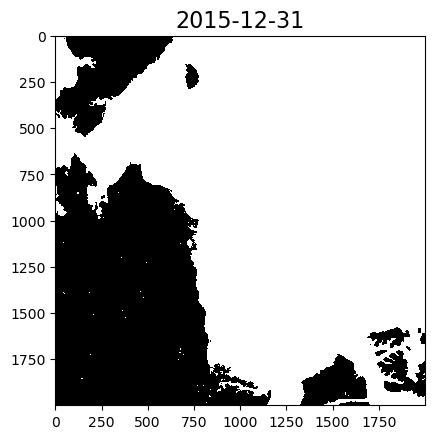

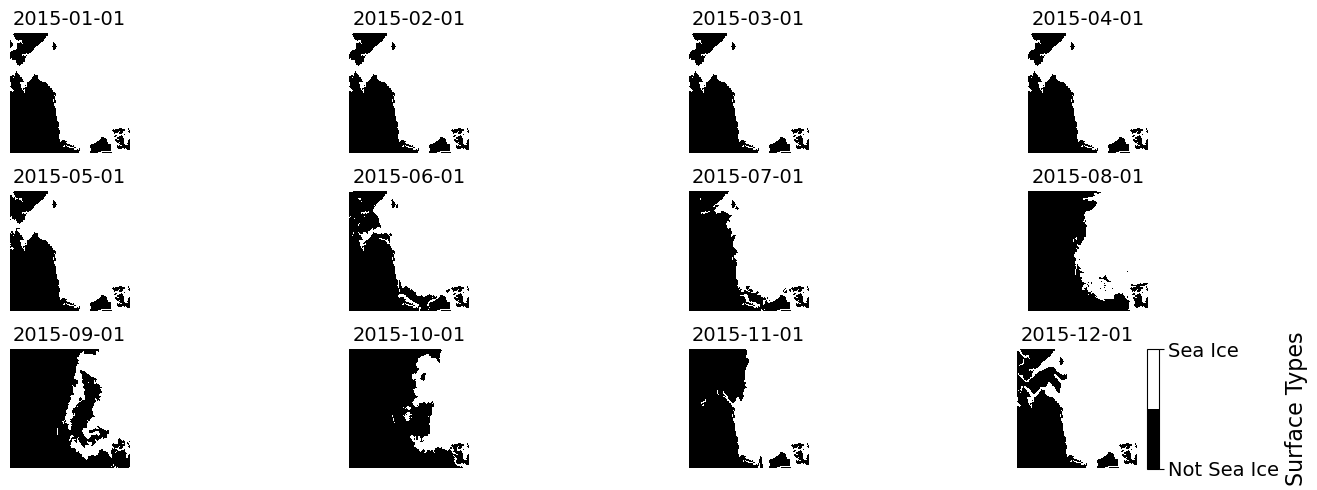

Cropping files for 2016


In [ ]:
for yr in analysis_years:
    print(f"Cropping files for {yr}")
    hdf5_dir = get_path([root_dir, yr])
    npy_save_dir = get_path([hdf5_dir, "npy"])
    os.makedirs(npy_save_dir, exist_ok=True)
    png_save_dir = get_path([hdf5_dir, "png"])
    os.makedirs(png_save_dir, exist_ok=True)

    file_list = glob.glob(get_path([hdf5_dir, "*.nc"]))
    crop_files(file_list, center_coordinates, npy_save_dir, png_save_dir)